<a href="https://colab.research.google.com/github/zhangminxi-bit/ECON3916/blob/main/ECON_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Petroleum', 'Price_2016': 1.72, 'Price_2024': 3.20},
]

# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Petroleum: 86.05% Inflation


In [5]:
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='010994d86a2a51dea5c209655a73fed8')

# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA')
streaming = fred.get_series('CUSR0000SERA02')
food = fred.get_series('CUSR0000SEFV')


In [17]:
def normalizing(data):
  base = data.loc['2016-01-01']
  for i in range(len(data)):
    data.iloc[i] = (data.iloc[i]/base)*100

normalizing(official_cpi)
normalizing(tuition)
normalizing(rent)
normalizing(streaming)
normalizing(food)


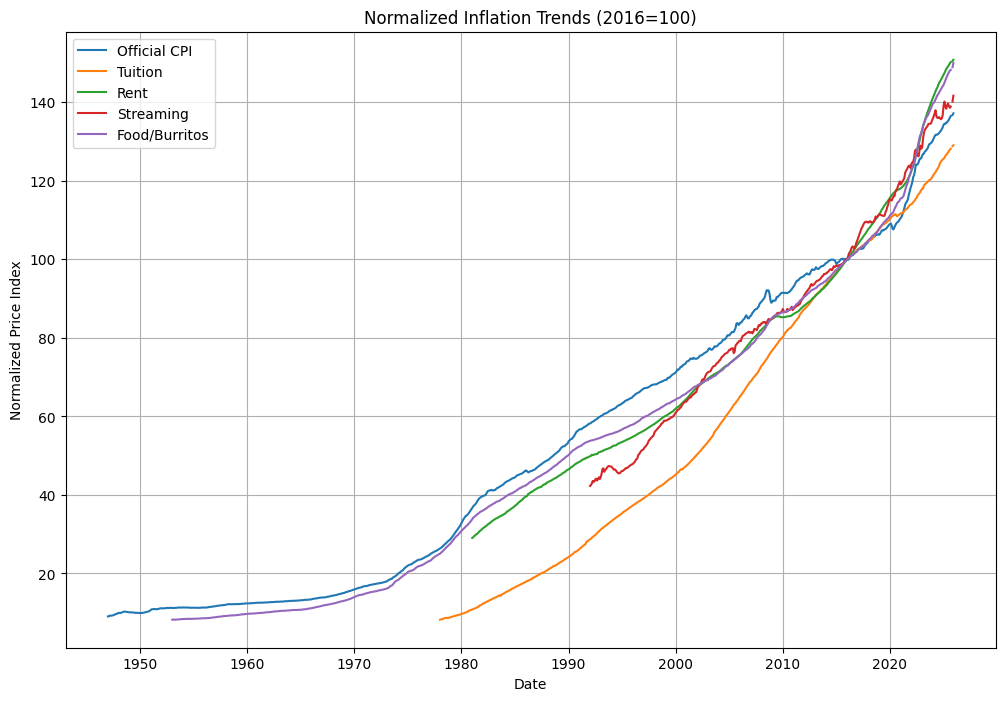

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(official_cpi, label='Official CPI')
plt.plot(tuition, label='Tuition')
plt.plot(rent, label='Rent')
plt.plot(streaming, label='Streaming')
plt.plot(food, label='Food/Burritos')

plt.title('Normalized Inflation Trends (2016=100)')
plt.xlabel('Date')
plt.ylabel('Normalized Price Index')
plt.legend()
plt.grid(True)
plt.show()

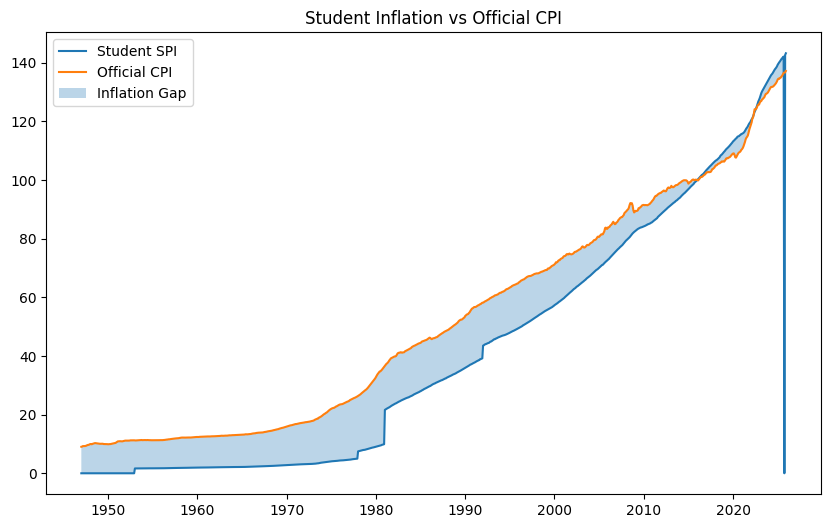

In [20]:
import pandas as pd

weights = {'rent':0.4, 'tuition': 0.3, 'streaming':0.1, 'food':0.2}

student_spi = (
    rent.reindex(official_cpi.index).fillna(0) * weights['rent'] +
    tuition.reindex(official_cpi.index).fillna(0) * weights['tuition'] +
    streaming.reindex(official_cpi.index).fillna(0) * weights['streaming'] +
    food.reindex(official_cpi.index).fillna(0) * weights['food']
)

df = pd.DataFrame({
    'Official CPI': official_cpi,
    'Student SPI': student_spi
})

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Student SPI'], label='Student SPI')
plt.plot(df.index, df['Official CPI'], label='Official CPI')

plt.fill_between(
    df.index,
    df['Student SPI'],
    df['Official CPI'],
    alpha=0.3,
    label='Inflation Gap'
)

plt.legend()
plt.title('Student Inflation vs Official CPI')
plt.show()

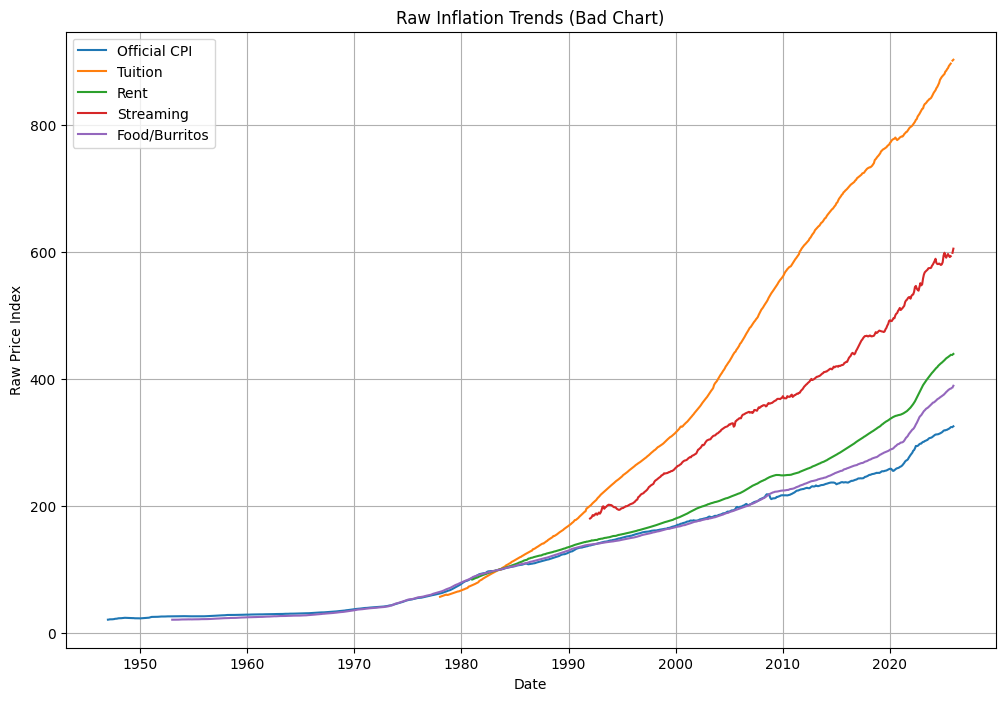

In [19]:
raw_official_cpi = fred.get_series('CPIAUCSL')
raw_tuition = fred.get_series('CUSR0000SEEB')
raw_rent = fred.get_series('CUSR0000SEHA')
raw_streaming = fred.get_series('CUSR0000SERA02')
raw_food = fred.get_series('CUSR0000SEFV')

plt.figure(figsize=(12, 8))
plt.plot(raw_official_cpi, label='Official CPI')
plt.plot(raw_tuition, label='Tuition')
plt.plot(raw_rent, label='Rent')
plt.plot(raw_streaming, label='Streaming')
plt.plot(raw_food, label='Food/Burritos')

plt.title('Raw Inflation Trends (Bad Chart)')
plt.xlabel('Date')
plt.ylabel('Raw Price Index')
plt.legend()
plt.grid(True)
plt.show()

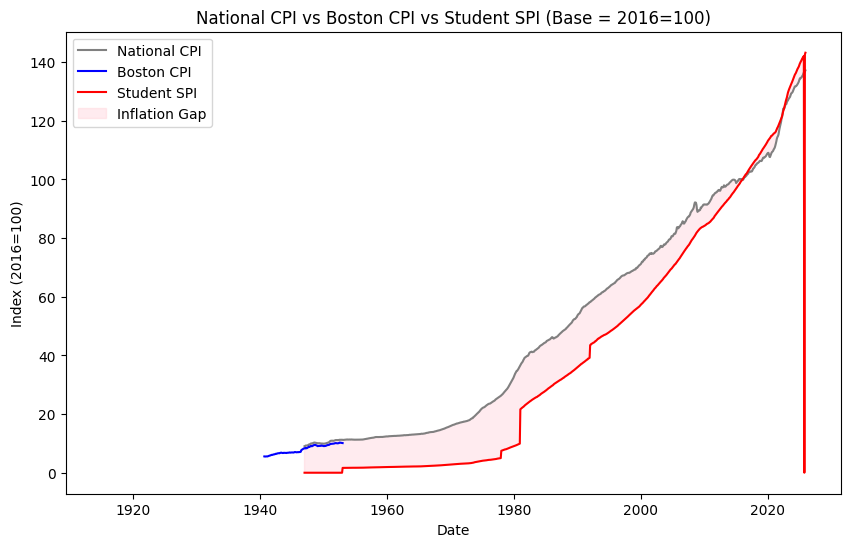

In [26]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

fred = Fred(api_key="010994d86a2a51dea5c209655a73fed8")

# 1) Fetch Boston CPI (CUURA103SA0)
boston = fred.get_series("CUURA103SA0")

# 2) Convert to DataFrame and re-index so 2016-01 = 100
boston = boston.to_frame(name="Boston_CPI")
boston.index = pd.to_datetime(boston.index)

# Find the 2016-01 value
base_val = boston.loc["2016-01-01", "Boston_CPI"]
boston["Boston_CPI"] = (boston["Boston_CPI"] / base_val) * 100

# 3) Make sure df has your existing normalized columns
df_plot = df.copy()
df_plot = df_plot.join(boston, how="outer")

# 4) Plot all three
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot["Official CPI"], color="grey", label="National CPI")
plt.plot(df_plot.index, df_plot["Boston_CPI"], color="blue", label="Boston CPI")
plt.plot(df_plot.index, df_plot["Student SPI"], color="red", label="Student SPI")

# fill between Student and National to highlight gap
plt.fill_between(
    df_plot.index,
    df_plot["Student SPI"],
    df_plot["Official CPI"],
    where=~df_plot["Student SPI"].isna(),
    color="pink",
    alpha=0.3,
    label="Inflation Gap"
)

plt.legend()
plt.title("National CPI vs Boston CPI vs Student SPI (Base = 2016=100)")
plt.xlabel("Date")
plt.ylabel("Index (2016=100)")
plt.show()

In [29]:
# Get the last valid values for Official CPI and Student SPI
last_official_cpi = df['Official CPI'].dropna().iloc[-1]
last_student_spi = df['Student SPI'].dropna().iloc[-1]

# Calculate the percentage divergence
divergence = ((last_student_spi - last_official_cpi) / last_official_cpi) * 100

print(f"Latest Official CPI: {last_official_cpi:.2f}")
print(f"Latest Student SPI: {last_student_spi:.2f}")
print(f"Divergence: {divergence:.2f}%")

Latest Official CPI: 137.19
Latest Student SPI: 143.22
Divergence: 4.40%
